In [1]:
!pip install timm albumentations scikit-learn opencv-python gradio kaggle --quiet

import os
import random
import numpy as np
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00


In [2]:
import torch
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU"
print(f"✅ GPU Available: {torch.cuda.is_available()} — {device_name}")

✅ GPU Available: True — Tesla T4


In [3]:
import shutil
import os

# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct location
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")

# Set correct permissions
!chmod 600 /root/.kaggle/kaggle.json

print("✅ Kaggle API key set up successfully")


✅ Kaggle API key set up successfully


In [4]:
!kaggle datasets download -d ayuraj/asl-dataset -p ./asl_dataset
!unzip -q ./asl_dataset/asl-dataset.zip -d ./asl_dataset
print("✅ Dataset downloaded & extracted successfully")


Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
  0% 0.00/56.9M [00:00<?, ?B/s]
100% 56.9M/56.9M [00:00<00:00, 1.23GB/s]
✅ Dataset downloaded & extracted successfully


In [25]:
import re
root_dir = "/content/asl_dataset/asl_dataset"
data_records = []

pattern = re.compile(r"(hand\d+)_(\w+)_(bot|top|left|right|dif)_seg_\d+_cropped\.jpeg", re.IGNORECASE)

for class_label in sorted(os.listdir(root_dir)):
    class_path = os.path.join(root_dir, class_label)
    if not os.path.isdir(class_path):
        continue
    for file in os.listdir(class_path):
        match = pattern.match(file)
        if match:
            hand, char, angle = match.groups()
            data_records.append({
                "class": class_label,
                "hand": hand,
                "angle": angle,
                "file_path": os.path.join(class_path, file)
            })

df = pd.DataFrame(data_records)

In [7]:
df.head()

,class,hand,angle,file_path
0,0,hand2,dif,/content/asl_dataset/asl_dataset/0/hand2_0_dif...
1,0,hand1,bot,/content/asl_dataset/asl_dataset/0/hand1_0_bot...
2,0,hand2,right,/content/asl_dataset/asl_dataset/0/hand2_0_rig...
3,0,hand1,dif,/content/asl_dataset/asl_dataset/0/hand1_0_dif...
4,0,hand4,bot,/content/asl_dataset/asl_dataset/0/hand4_0_bot...


In [8]:
print("Total images:", len(df))

Total images: 2515


In [9]:
print("Unique classes:", df['class'].nunique())

Unique classes: 36


# Count of each class 0-9 & a-z


In [10]:
print("\nCounts per class:")
print(df['class'].value_counts())


Counts per class:
class
0    70
1    70
2    70
3    70
4    70
5    70
6    70
7    70
8    70
9    70
a    70
b    70
c    70
d    70
e    70
f    70
g    70
h    70
i    70
j    70
k    70
l    70
m    70
n    70
o    70
p    70
q    70
r    70
s    70
u    70
v    70
w    70
y    70
x    70
z    70
t    65
Name: count, dtype: int64


# Count of Class VS Hand

In [19]:
print("\nCounts per (class, hand):")
df.groupby(['class', 'hand']).size().reset_index()


Counts per (class, hand):


,class,hand,0
0,0,hand1,25
1,0,hand2,25
2,0,hand3,5
3,0,hand4,5
4,0,hand5,10
...,...,...,...
175,z,hand1,25
176,z,hand2,25
177,z,hand3,5
178,z,hand4,5


<Figure size 1200x600 with 0 Axes>

# Count of Class VS Angle

In [20]:
print("\nCounts per (class, angle):")
df.groupby(['class', 'angle']).size().reset_index()


Counts per (class, angle):


,class,angle,0
0,0,bot,20
1,0,dif,20
2,0,left,10
3,0,right,10
4,0,top,10
...,...,...,...
175,z,bot,20
176,z,dif,20
177,z,left,10
178,z,right,10


# Count of Class VS Hand VS Angle

In [22]:
print("\nCounts per (class, hand, angle):")
df.groupby(['class', 'hand', 'angle']).size().reset_index()


Counts per (class, hand, angle):


,class,hand,angle,0
0,0,hand1,bot,5
1,0,hand1,dif,5
2,0,hand1,left,5
3,0,hand1,right,5
4,0,hand1,top,5
...,...,...,...,...
498,z,hand2,top,5
499,z,hand3,dif,5
500,z,hand4,bot,5
501,z,hand5,bot,5


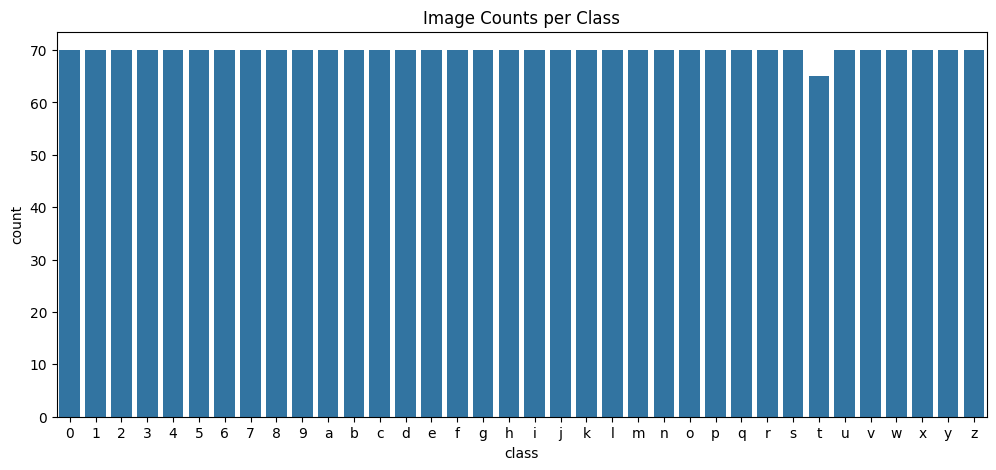

In [14]:
import seaborn as sns
plt.figure(figsize=(12,5))
sns.countplot(x='class', data=df, order=sorted(df['class'].unique()))
plt.title("Image Counts per Class")
plt.show()

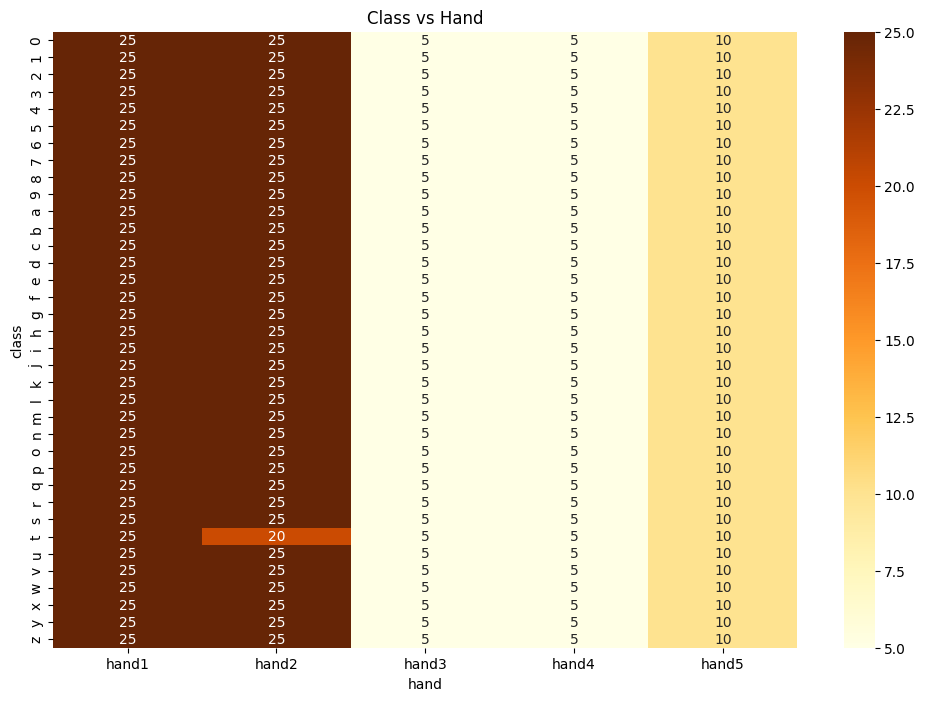

In [15]:
plt.figure(figsize=(12,8))
pivot_hand = df.groupby(['class', 'hand']).size().unstack(fill_value=0)
sns.heatmap(pivot_hand, annot=True, fmt='d', cmap="YlOrBr")
plt.title("Class vs Hand")
plt.show()

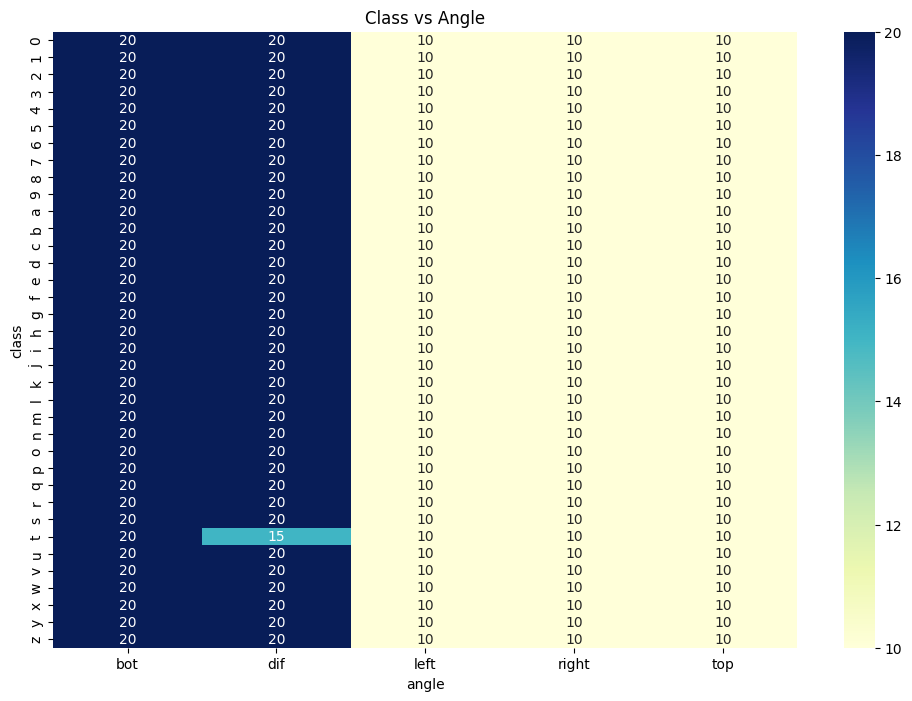

In [16]:

plt.figure(figsize=(12,8))
pivot_angle = df.groupby(['class', 'angle']).size().unstack(fill_value=0)
sns.heatmap(pivot_angle, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Class vs Angle")
plt.show()

/tmp/ipython-input-1543347804.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby(['class', 'hand', 'angle']).apply(lambda x: x.sample(min(2, len(x)), random_state=42)).reset_index(drop=True)


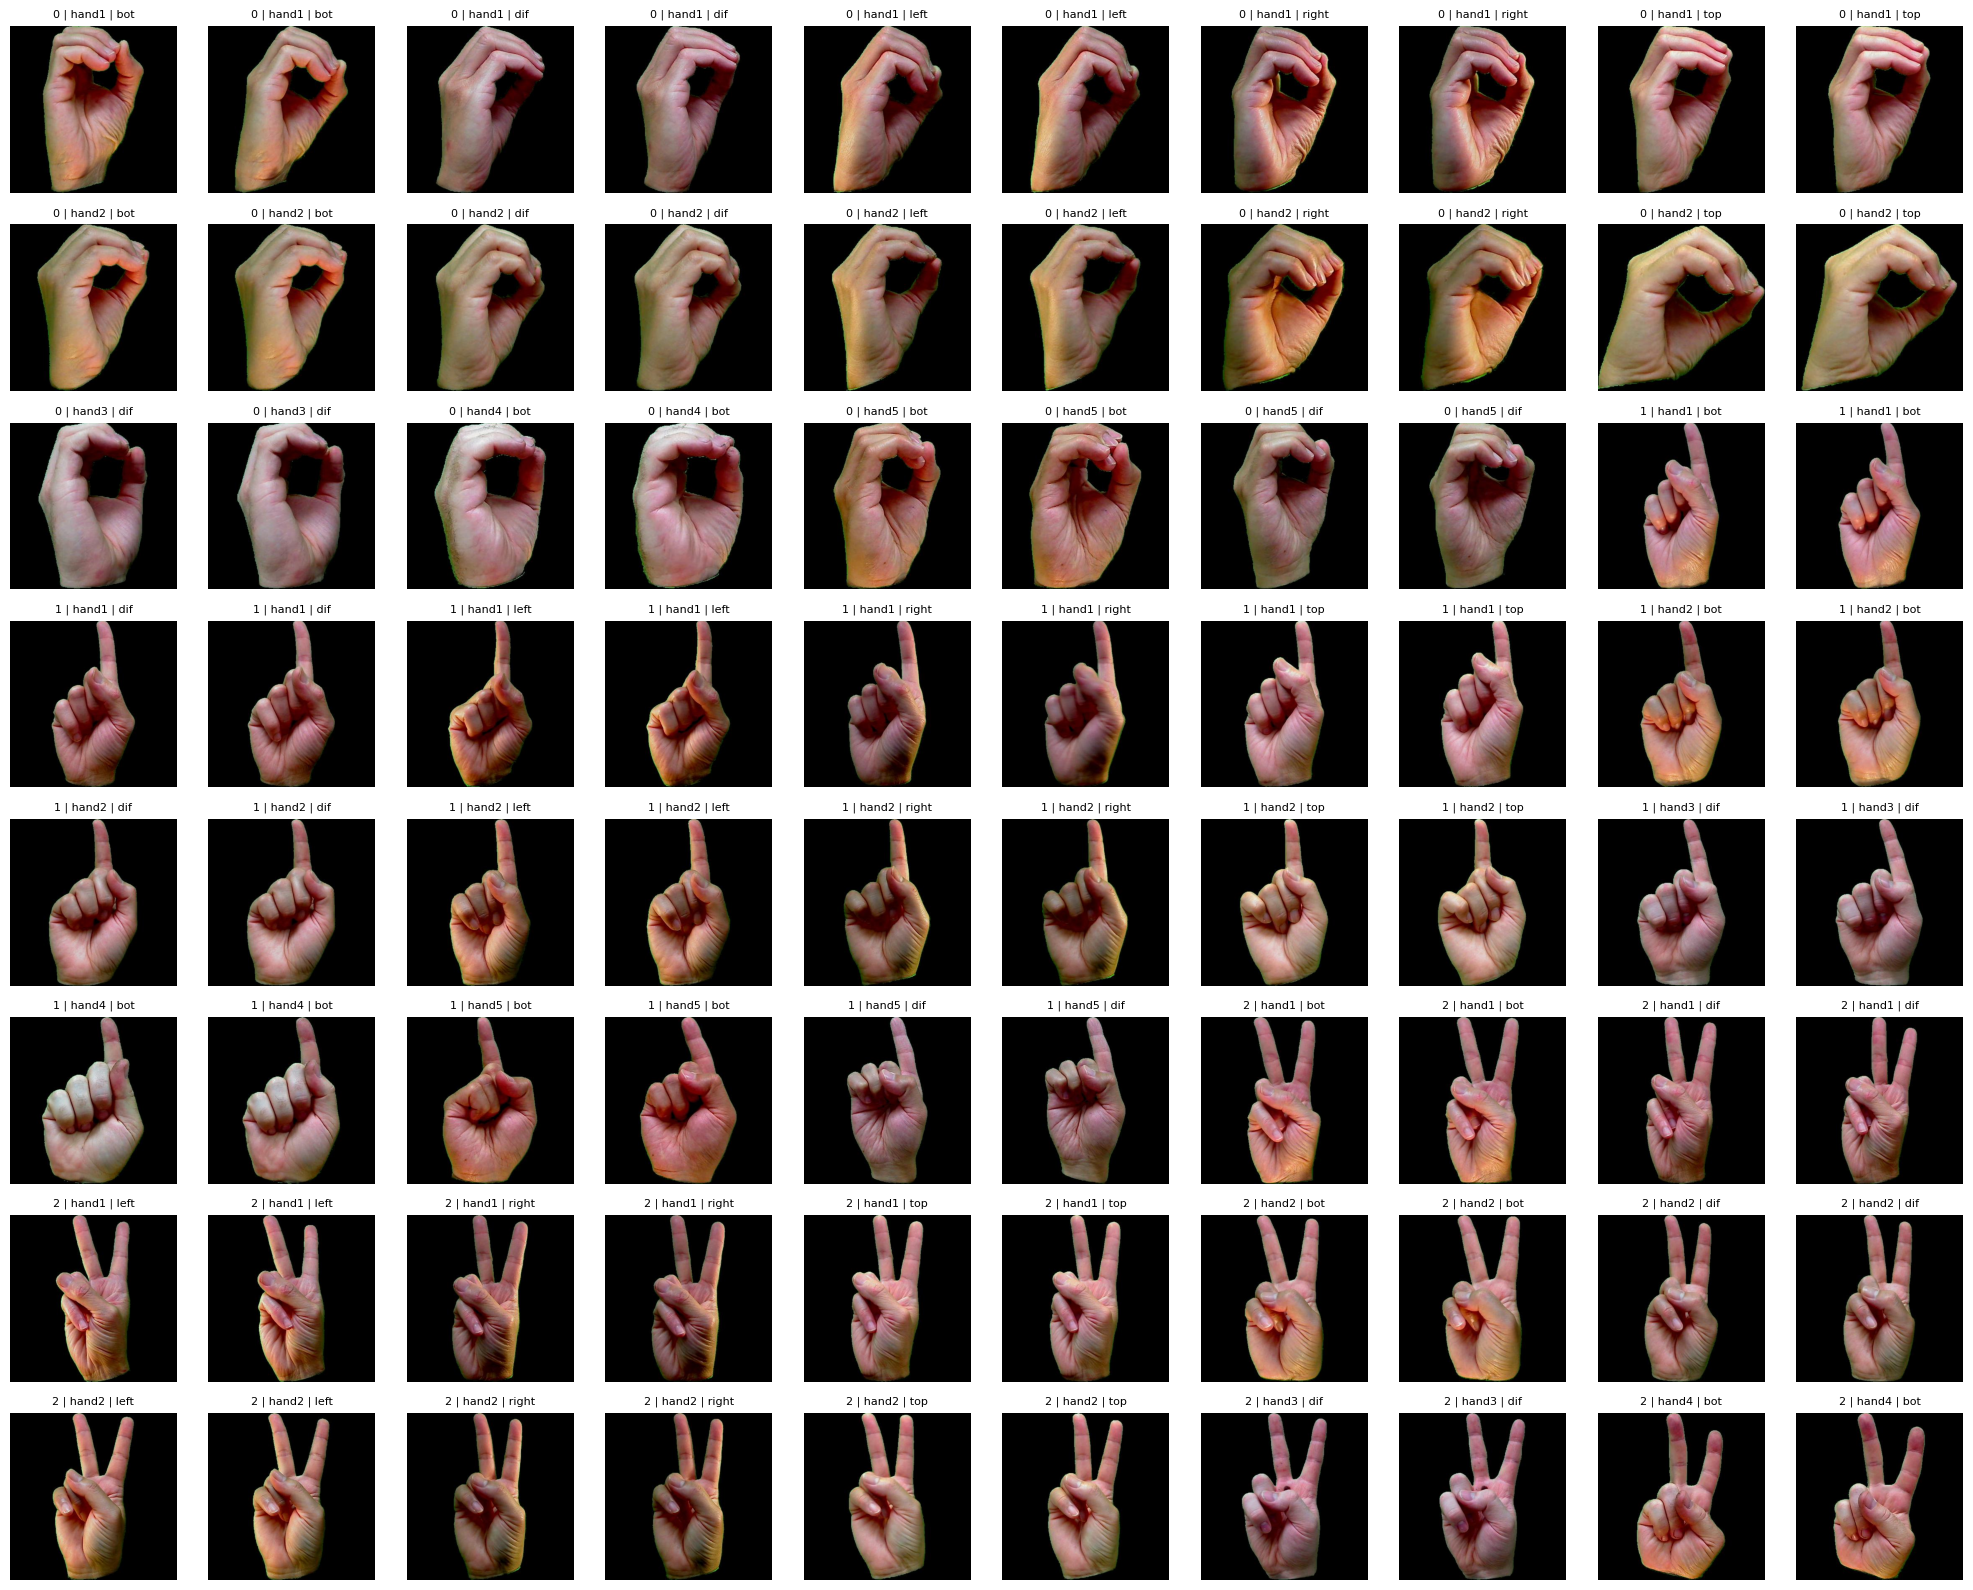

In [17]:
from PIL import Image
sample_df = df.groupby(['class', 'hand', 'angle']).apply(lambda x: x.sample(min(2, len(x)), random_state=42)).reset_index(drop=True)

fig, axes = plt.subplots(8, 10, figsize=(20,16))
axes = axes.flatten()

for i, (_, row) in enumerate(sample_df.iterrows()):
    if i >= len(axes):
        break
    img = Image.open(row['file_path'])
    axes[i].imshow(img)
    axes[i].set_title(f"{row['class']} | {row['hand']} | {row['angle']}", fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Count of Hand VS Angle

angle  bot  dif  left  right  top
hand                             
hand1  180  180   180    180  180
hand2  180  175   180    180  180
hand3    0  180     0      0    0
hand4  180    0     0      0    0
hand5  180  180     0      0    0


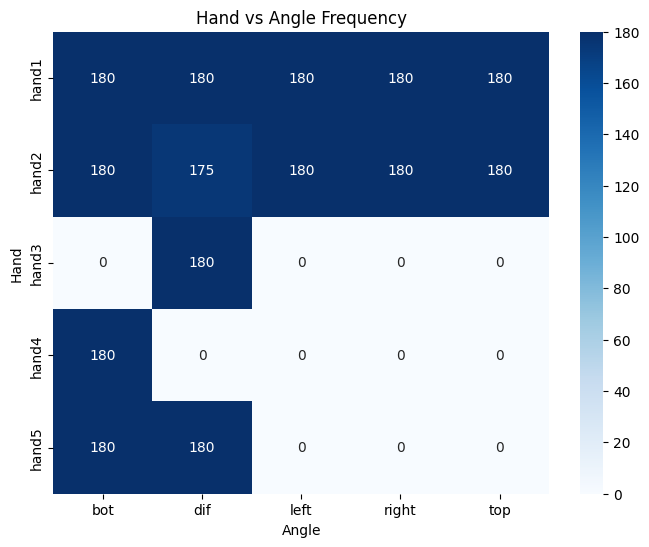

In [23]:
# Count per (hand, angle) combination
hand_angle_counts = df.groupby(['hand', 'angle']).size().unstack(fill_value=0)

print(hand_angle_counts)

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(hand_angle_counts, annot=True, fmt='d', cmap='Blues')
plt.title('Hand vs Angle Frequency')
plt.xlabel('Angle')
plt.ylabel('Hand')
plt.show()


# Percentage of Hand coverage of angles & Missing Hand and Angle combinations

In [24]:
import pandas as pd

# Count occurrences per hand-angle
hand_angle_counts = df.groupby(["hand", "angle"]).size().unstack(fill_value=0)

# Define coverage score (present = 1, missing = 0)
coverage_binary = (hand_angle_counts > 0).astype(int)

# Calculate coverage percentage
coverage_score = coverage_binary.mean(axis=1) * 100

# Find missing combinations
missing_combos = [
    (hand, angle)
    for hand in hand_angle_counts.index
    for angle in hand_angle_counts.columns
    if hand_angle_counts.loc[hand, angle] == 0
]

# Display results
print("=== Coverage Score (%) per Hand ===")
print(coverage_score)
print("\n=== Missing (Hand, Angle) Combinations ===")
for combo in missing_combos:
    print(combo)


=== Coverage Score (%) per Hand ===
hand
hand1    100.0
hand2    100.0
hand3     20.0
hand4     20.0
hand5     40.0
dtype: float64

=== Missing (Hand, Angle) Combinations ===
('hand3', 'bot')
('hand3', 'left')
('hand3', 'right')
('hand3', 'top')
('hand4', 'dif')
('hand4', 'left')
('hand4', 'right')
('hand4', 'top')
('hand5', 'left')
('hand5', 'right')
('hand5', 'top')
